# Decoding stimulus identity from neural responses

We implement here a nearest-neighbor decoder of neural activity.

In [1]:
# general modules
import pynwb, os, sys, pprint, itertools
import numpy as np
import matplotlib.pylab as plt

# custom modules
sys.path.append('../physion')
from dataviz.show_data import MultimodalData, EpisodeResponse
from datavyz import graph_env_manuscript as ge

pygame 2.1.2 (SDL 2.0.16, Python 3.7.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
filename = '/home/yann.zerlaut/DATA/curated/2022_03_16-16-21-18.nwb'
filename = '/home/yann.zerlaut/DATA/curated/2022_03_31-16-12-35.nwb'
filename = '/home/yann.zerlaut/DATA/curated/2022_05_30-16-46-56.nwb'
data = MultimodalData(filename)

episodes_NI = EpisodeResponse(filename, 
                           quantities=['dFoF', 'rawFluo', 'pupil', 'Running-Speed', 'facemotion'], 
                           protocol_id=1,
                           verbose=True, prestim_duration=1.5)

episodes_GB = EpisodeResponse(filename, 
                           quantities=['dFoF', 'rawFluo', 'pupil', 'Running-Speed', 'facemotion'], 
                           protocol_id=0,
                           verbose=True, prestim_duration=1.5)

print('episodes_NI:', episodes_NI.protocol_name)
print('episodes_GB:', episodes_GB.protocol_name)

NWB-file reading time: 166.2ms
  Number of episodes over the whole recording: 90/180 (with protocol condition)
  building episodes with 5 modalities [...]

calculating dF/F with method "maximin" [...]

  ** 1 ROIs were discarded with the positive F0 criterion (0.4%) ** 

-> dFoF calculus done !  (calculation took 0.5s)
----
A value in x_new is above the interpolation range.
-2.990000000000009 9.470000000000027 8.0
Problem with episode 179 between (1796.49, 1804.49)s
  -> [ok] episodes ready !
NWB-file reading time: 182.4ms
  Number of episodes over the whole recording: 90/180 (with protocol condition)
  building episodes with 5 modalities [...]

calculating dF/F with method "maximin" [...]

  ** 1 ROIs were discarded with the positive F0 criterion (0.4%) ** 

-> dFoF calculus done !  (calculation took 0.4s)
  -> [ok] episodes ready !
episodes_NI: NI-VSE-3images-1vse-30trials
episodes_GB: gaussian-blobs


In [3]:
print('\n -* Varied Parameters *- \n')
VP = [key for key in episodes_NI.varied_parameters if key!='repeat'] # varied parameters except rpeat
print(VP)


 -* Varied Parameters *- 

['Image-ID']


In [22]:
episodes=episodes_NI
SUMMARY = {'significant_rois':[[] for i in range(np.product([len(episodes.varied_parameters[key]) for key in VP]))],
           'stim_pair':[[0,0], [0,1], [1,0], [1,1]]}
duration = episodes.data.metadata['Protocol-%i-presentation-duration' % (episodes.protocol_id+1)]
value_threshold = .2
# looping over neurons
for roi in range(episodes.data.nROIs):
    roi_summary = episodes.compute_summary_data(dict(interval_pre=[-2,0], 
                                                      interval_post=[0,duration],
                                                      test='wilcoxon', 
                                                      positive=True),
                                                 response_args={'quantity':'dFoF', 
                                                                'roiIndex':roi},
                                               response_significance_threshold=0.01)
    for istim in range(len(roi_summary['significant'])):
        if roi_summary['significant'][istim] and (roi_summary['value'][istim]>value_threshold):
            SUMMARY['significant_rois'][istim].append(roi)           
            
print(SUMMARY['significant_rois'])
print(roi_summary)


[[1, 5, 6, 9, 12, 15, 17, 19, 20, 25, 31, 34, 35, 42, 45, 49, 79, 88, 92, 104, 106, 119, 128, 134, 154, 161, 177, 196, 198, 203, 205, 219, 237, 249, 250, 262], [1, 2, 5, 6, 7, 10, 11, 17, 18, 19, 20, 31, 36, 37, 45, 79, 107, 112, 119, 125, 126, 132, 149, 154, 185, 188, 205, 232, 249, 250], [2, 5, 6, 14, 18, 20, 31, 42, 45, 61, 64, 79, 104, 110, 118, 119, 144, 149, 154, 236, 238]]
{'value': array([0.16133091, 0.12544252, 0.05515161]), 'significant': array([ True,  True,  True]), 'relative_value': array([0.36529026, 0.28279531, 0.1261252 ]), 'Image-ID': array([1., 2., 3.]), 'Image-ID-bins': array([0.5, 1.5, 2.5, 3.5])}


In [ ]:
stim_index = 2
SUMMARY['stim_pair']:[[0,0], [0,1], [0,2], [0,3]]
np.random.seed(1)
Nrois = min(len(SUMMARY['significant_rois'][stim_index]), 8)
fig = episodes.plot_evoked_pattern(episodes.find_episode_cond(VP, SUMMARY['stim_pair'][stim_index]),
                                   rois=np.random.choice(SUMMARY['significant_rois'][stim_index], Nrois,replace=False),
                                   quantity='dFoF')
ge.save_on_desktop(fig)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

def run_model(episodes, key, condition, seed=1):
    X_train, X_test, y_train, y_test = train_test_split([episodes.dFoF[i,:,:].flatten() for i in range(episodes.dFoF.shape[0])],
                                                        getattr(episodes, key),
                                                        test_size=0.5, random_state=seed)
    #print(X_train.shape)
    nn_model = KNeighborsClassifier(n_neighbors=1, algorithm='brute').fit(X_train, y_train)
    y_predicted = nn_model.predict(X_test)
    return np.sum((y_predicted-y_test)==0)/len(y_test)

In [ ]:
episodes = episodes_NI
threshold = .7
All = np.ones(episodes_NI.shape[0], dtype=str)
High = 
#Low = 
print(High)

In [12]:
accuracies_NI_all = [run_model(episodes_NI, 'Image-ID', seed=i) for i in range(5)]

In [13]:
accuracies_GB = [run_model(episodes_GB, 'center-time', seed=i) for i in range(5)]

In [6]:
print(accuracies_NI_all, accuracies_GB)
ge.bar([100*np.mean(accuracies_NI_all), 100*np.mean(accuracies_GB)], sy=[100*np.std(accuracies_NI_all), 100*np.std(accuracies_GB)])

NameError: name 'accuracies_NI_all' is not defined

(<Figure size 119.055x102.047 with 1 Axes>,
 <AxesSubplot:xlabel='pupil size', ylabel='count'>)

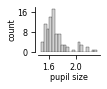

In [15]:
ge.hist(episodes.pupilSize.mean(axis=1), xlabel='pupil size')

(<Figure size 119.055x102.047 with 1 Axes>,
 <AxesSubplot:xlabel='pupil size', ylabel='count'>)

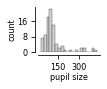

In [18]:
ge.hist(episodes.faceMotion.mean(axis=1), xlabel='face-motion')

(<Figure size 119.055x102.047 with 1 Axes>,
 <AxesSubplot:xlabel='pupil size', ylabel='count'>)

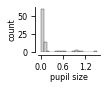

In [21]:
ge.hist(episodes.RunningSpeed.mean(axis=1), xlabel='face-motion')

(<Figure size 119.055x102.047 with 1 Axes>, <AxesSubplot:>)

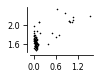

In [23]:
ge.scatter(episodes.RunningSpeed.mean(axis=1),episodes.pupilSize.mean(axis=1))

(<Figure size 119.055x102.047 with 1 Axes>, <AxesSubplot:>)

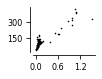

In [22]:
ge.scatter(episodes.RunningSpeed.mean(axis=1), episodes.faceMotion.mean(axis=1))

In [ ]:
fig, AX = ge.figure(axes_extents=[[[1,3] for i in range(4)],
                                  [[1,9] for i in range(4)]], 
                     figsize=(1.3, .3), left=0.3,
                     top=12, right=3, wspace=1.2)
 

for stim_index in range(4):
    np.random.seed(6)
    episodes.plot_evoked_pattern(episodes.find_episode_cond(VP, SUMMARY['stim_pair'][stim_index]),
                                   rois=np.random.choice(SUMMARY['significant_rois'][stim_index], 8, replace=True),
                                   quantity='dFoF',
                                 axR=AX[0][stim_index], axT=AX[1][stim_index])
#ge.save_on_desktop(fig, 'fig.png')

In [71]:
# general modules
import pynwb, os, sys, pprint, itertools
import numpy as np
import matplotlib.pylab as plt

# custom modules
sys.path.append('../physion')
from analysis.read_NWB import Data
from dataviz.show_data import MultimodalData, EpisodeResponse
from datavyz import graph_env_manuscript as ge
#filename = '/home/yann.zerlaut/DATA/2022_05_30-16-46-56.nwb'
filename = '/home/yann.zerlaut/DATA/curated/2022_03_31-15-43-55.nwb'
filename = '/home/yann.zerlaut/DATA/curated/2022_03_01-15-25-17.nwb'
data = Data(filename, metadata_only=True)
print(data.protocols)

episodes = EpisodeResponse(filename, quantities=['dFoF', 'Zscore_dFoF'], 
                           verbose=True, prestim_duration=1.5,
                           protocol_id=1)

['spatial-mapping-fast' 'gaussian-blobs']
NWB-file reading time: 156.8ms
  Number of episodes over the whole recording: 120/300 (with protocol condition)
  building episodes with 2 modalities [...]

calculating dF/F with method "maximin" [...]

  ** all ROIs passed the positive F0 criterion ** 

-> dFoF calculus done !  (calculation took 1.1s)
  -> [ok] episodes ready !



 there are several modalities in that episode
     -> need to define the desired quantity, here taking: "dFoF"
X-bar label automatically set to:  1.1  Using the format %.1f  --> adjust it and add units through the format !
Y-bar label automatically set to:  0.3  Using the format %.1f  --> adjust it and add units through the format !


{'center-time': array([2., 4., 6.]),
 'radius': array([10., 25.]),
 'repeat': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int32)}

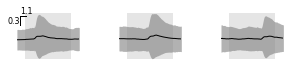

In [72]:
episodes.plot_trial_average(column_key='center-time', roiIndices='all')
episodes.varied_parameters

In [76]:
SUMMARY = {'significant_rois':[[] for i in range(len(episodes.varied_parameters['center-time']))]}

duration = episodes.data.metadata['Protocol-2-presentation-duration']
#duration = episodes.data.metadata['presentation-duration']
    
value_threshold = .6
# looping over neurons
for roi in range(episodes.data.nROIs):
    roi_summary = episodes.compute_summary_data(dict(interval_pre=[-2,0], 
                                                     #interval_post=[0,duration],
                                                     interval_post=[2,3],
                                                      test='wilcoxon', 
                                                      positive=True),
                                                 response_args={'quantity':'dFoF', 
                                                                'roiIndex':roi},
                                               response_significance_threshold=0.01)
    for istim, stim in enumerate(episodes.varied_parameters['center-time']):
        if roi_summary['significant'][istim] and (roi_summary['value'][istim]>value_threshold):
            SUMMARY['significant_rois'][istim].append(roi)
            

[24, 30, 96, 34, 197, 199, 18, 91]


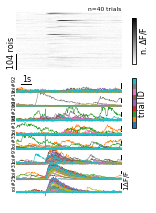

In [96]:
stim_index = 0
np.random.seed(4)
Nrois = min(len(SUMMARY['significant_rois'][stim_index]), 3)

rois = list(np.random.choice(SUMMARY['significant_rois'][stim_index], 3,replace=False))+list(np.random.choice(np.arange(200),5, replace=False))
print(rois)
fig = episodes.plot_evoked_pattern(episodes.find_episode_cond('center-time',stim_index),
                                   rois=rois,
                                   quantity='dFoF', with_stim_inset=False)
ge.save_on_desktop(fig)

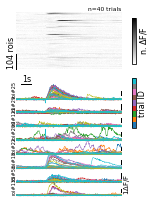

In [97]:
stim_index = 0
rois = [134, 52, 17, 21, 199, 120, 28, 24]
fig = episodes.plot_evoked_pattern(episodes.find_episode_cond('center-time',stim_index),
                                   rois=rois,
                                   quantity='dFoF', with_stim_inset=False)
ge.save_on_desktop(fig)